In [ ]:
"""
Regression Discontinuity Design (RDD) on Student Performance via Scholarship Eligibiilty
---

🔍 **Situation**:
    A university awards a merit-based scholarship to students who score 80 or higher
    on their entrance exam. We want to determine whether receiving the scholarship has
    a causal impact on final GPA using a Regression Discontinuity Design (RDD).

📌 **Task**:
    Estimate the jump in final GPA at the scholarship eligibility cutoff (exam score = 80)
    using an RDD framework. The goal is to measure the true effect of the
    scholarship by comparing students just above and below the threshold.

✨ **Action**: 
    Centered the exam score around the threshold (x = exam_score - 80).
    Applied local linear regression with an interaction term.
    Used the causalpy package to estimate the discontinuity at the threshold.

📈 **Result**:
    Receiving the scholarship increases final GPA by 0.38 (94% HDI [0.31, 0.45]).
    The baseline GPA (for students at the threshold) is 4.9.
    The GPA trend is slightly weaker for scholarship recipients, suggesting diminishing returns at higher scores.
    The standard deviation of GPA is 0.2, showing moderate variability.

🚀 Next Steps / Additional Analysis
    Placebo Tests: Check for discontinuities at non-policy cutoffs.
    Bandwidth Sensitivity: Test different windows around the cutoff.
    Covariate Adjustments: Control for other factors like socioeconomic status.

✍ **Author**: Justin Wall
📅 **Updated**: 03/12/2025
"""

'\nRegression Discontinuity Design (RDD) on Student Performance via Scholarship Eligibiilty\n---\n\n🔍 **Situation**:\n    A university awards a merit-based scholarship to students who score 80 or higher\n    on their entrance exam. We want to determine whether receiving the scholarship has\n    a causal impact on final GPA using a Regression Discontinuity Design (RDD).\n\n📌 **Task**:\n    Estimate the jump in final GPA at the scholarship eligibility cutoff (exam score = 80)\n    using an RDD framework. The goal is to measure the true effect of the\n    scholarship by comparing students just above and below the threshold.\n\n✨ **Action**: \n    Centered the exam score around the threshold (x = exam_score - 80).\n    Applied local linear regression with an interaction term.\n    Used the causalpy package to estimate the discontinuity at the threshold.\n\n📈 **Result**:\n    Receiving the scholarship increases final GPA by 0.38 (94% HDI [0.31, 0.45]).\n    The baseline GPA (for students at

In [10]:
# =================================
# Import Libraries and Create Data
# =================================
#%%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import causalpy as cp
import seaborn as sns
import statsmodels.api as sm
import arviz as az


# Set random seed for reproducibility
np.random.seed(42)

# Define parameters
n_users = 200  # Total users (100 per group)
weeks = 8  # 4 weeks before and 4 weeks after treatment
treatment_start = 4  # Week index when the feature is released

# Create DataFrame structure
data = []
for user_id in range(n_users):
    group = 'treatment' if user_id < n_users / 2 else 'control'
    
    for week in range(weeks):
        base_minutes = 50 + np.random.normal(0, 5)  # Baseline engagement with some noise
        treatment_effect = 10 if (group == 'treatment' and week >= treatment_start) else 0  # Feature effect
        
        engagement = base_minutes + treatment_effect + np.random.normal(0, 3)  # Add random variation
        
        data.append([user_id, group, week, engagement])

# Create DataFrame
df = pd.DataFrame(data, columns=['user_id', 'group', 'week', 'weekly_active_minutes'])

# View first few rows
print(df.head())
#%%

   user_id      group  week  weekly_active_minutes
0        0  treatment     0              52.068778
1        0  treatment     1              57.807532
2        0  treatment     2              48.126822
3        0  treatment     3              60.198368
4        0  treatment     4              59.280308


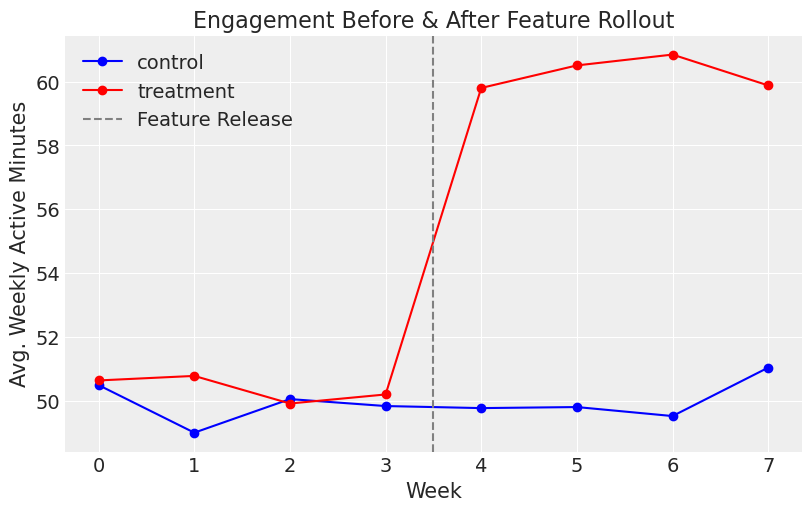

In [11]:
# ==========================
# Visualize Treatment Effect
# ==========================
#%%
# Plot engagement trends
plt.figure(figsize=(8, 5))
for grp, color in zip(['control', 'treatment'], ['blue', 'red']):
    mean_trend = df[df['group'] == grp].groupby('week')['weekly_active_minutes'].mean()
    plt.plot(mean_trend, marker='o', linestyle='-', label=grp, color=color)

plt.axvline(x=treatment_start - 0.5, color='gray', linestyle='--', label="Feature Release")
plt.xlabel("Week")
plt.ylabel("Avg. Weekly Active Minutes")
plt.title("Engagement Before & After Feature Rollout")
plt.legend()
plt.show()
#%%

In [12]:
# Edit features to match DiD example
# Convert week index into a binary indicator for pre/post period
df['post_treatment'] = (df['week'] >= treatment_start).astype(bool)
df = df.rename(columns={'weekly_active_minutes':'y','week':'t'})
df.head()

,user_id,group,t,y,post_treatment
0,0,treatment,0,52.068778,False
1,0,treatment,1,57.807532,False
2,0,treatment,2,48.126822,False
3,0,treatment,3,60.198368,False
4,0,treatment,4,59.280308,True


In [ ]:
# ==========================
# Estimate Treatment Effect
# ==========================
#%%
# Run Difference-in-Differences using causalpy
model = cp.DifferenceInDifferences(
    df,
    formula="y ~ 1 + post_treatment * group",
    time_variable_name="t",
    group_variable_name="group",
    model=cp.pymc_models.LinearRegression(
        sample_kwargs={
            "target_accept": 0.95,
        }
    )
)

# Display results
print(model.summary())
#%%

DataException: Require a `unit` column to label unique units. This is used for plotting purposes

In [ ]:

# Plot results
az.plot_posterior(model.posterior_, var_names=["post_treatment:group[T.treatment]"], ref_val=0)
plt.title("Posterior Distribution of Treatment Effect")
plt.show()